## Проект поиска ближайших соседей - MATCHING.

**Описание проекта** 

Дано 2-а множества объектов: А и Б. Каждый объект в множестве описывается закодированными признаками. В результате необходимо для каждого объекта из множества А найти несколько объектов из Б, которые наиболее близки к нему по некоротой, заданной, метрике.

**Исходные данные** 

**base.csv** - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72. 

**target.csv** - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

**validation.csv** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

**validation_answer.csv** - правильные ответы к предыдущему файлу. 

Описания признаков нет, так как они не именнованные.


**План работы**

1) Загрузить данные
2) Прочитать дополнительные материалы
3) Понять задачу
4) Повторить baseline
5) Провести EDA и повысить качество
6) Исследовать опции FAISS 
7) Разработать ранжирующую модель


Произведем импорты необходимых библиотек.

In [2]:
import pandas as pd
import numpy as np

import faiss

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, ConfusionMatrixDisplay

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from faiss import StandardGpuResources

RANDOM_STATE = 42
CLUSTERS = 10  # кол-во кластеров для деления векторного пространства
NEIGHBORS = 5# кол-во ближайших соседей
CELLS = 5 

Произведем настройку отображения данных.

In [2]:
pd.options.display.float_format ='{:,.5f}'.format
pd.set_option('display.max_columns', None)

Загрузим данные и сохраним их в переменные. 

In [3]:
data_base = pd.read_csv('base.csv')

In [4]:
data_train = pd.read_csv('train.csv')

In [5]:
data_validation = pd.read_csv('validation.csv')

In [6]:
data_validation_answer = pd.read_csv('validation_answer.csv')

Создадим функцию для отображения основных данных.

In [7]:
def read_data(data):
    name='data_'+data[:-4]
    print(name)
    name= pd.read_csv(data)
    name.info()
    display(name.head(5))
    print('Пропуски:')
    print(round(name.isna().sum()))
    print('Дупликаты:')
    print(name.duplicated().sum())

In [8]:
read_data('base.csv')

data_base
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      flo

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.08389,11.15291,-64.42676,-118.88089,216.48244,-104.69806,-469.07059,44.34808,120.91534,181.44970,-124.06151,-32.45824,-57.42056,36.20741,182.71677,-28.07169,-5.20937,-1.73218,-91.09186,-79.46667,-103.93909,"1,507.23127",-32.59167,51.41436,-51.90536,813.77007,-41.55654,8.41981,-129.97664,148.76503,-10.06923,-143.00504,79.84869,-537.18371,2.77318,111.51868,4.25767,-153.34058,-123.62608,-39.70766,-12.76871,-4.17011,-152.96713,75.91152,-57.47009,17.26648,-98.87116,-138.06754,91.00038,-170.70200,-50.02039,59.79430,78.10638,-89.37573,89.41210,79.81218,-129.51361,-44.65950,-80.44221,5.14971,-64.51895,-138.77763,-42.80869,38.80083,-151.76218,-74.38909,63.66634,-4.70386,92.93361,115.26919,-112.75664,-60.83035
1,1-base,-34.56220,13.33276,-69.78761,-166.53348,57.68061,-86.09837,-85.07667,-35.63744,119.71864,195.23419,-141.30435,-126.76890,-68.85353,8.31472,143.08174,8.77826,15.15719,48.24636,-244.95486,-80.27942,-81.78804,429.88004,-5.93769,70.14265,66.57684,813.77007,3.21437,17.16430,-39.41839,148.15588,-7.57959,-174.36995,101.22463,-303.93923,16.91463,53.39468,33.45182,-148.55263,-110.34017,-33.27721,-8.68870,13.65030,-91.22875,38.44501,-31.94847,62.48482,-166.47336,-189.01042,-56.73156,-30.02732,59.17106,-56.71154,63.54261,-121.31917,97.42606,74.83284,-138.77705,58.88761,-71.59534,-251.95236,11.39285,-148.57166,-117.76753,41.10000,-157.82940,-94.44681,68.20211,24.34685,179.93793,116.83400,-84.88894,-59.52461
2,2-base,-54.23375,6.37937,-29.21014,-133.41383,150.89583,-99.43533,52.55480,62.38171,128.95145,164.38147,-140.82245,-22.48675,-51.66699,2.52173,140.58545,-22.03923,-7.12863,-5.18479,-111.71212,-79.02927,-82.45258,"1,507.23127",-0.42101,84.10801,63.34451,813.77007,-105.21105,18.84470,-94.78947,151.38771,-21.48344,-144.84537,48.50293,-780.44918,64.76731,79.78155,-13.39014,-150.06166,-118.75855,-40.89629,-15.22262,-1.86034,-93.82066,98.74907,-46.74578,65.92748,-10.28639,-125.32137,21.04861,-22.63778,68.91599,-54.90226,66.33547,-142.92792,83.03098,69.97963,-123.73389,65.32088,-114.03718,-529.39696,-101.58137,-134.65822,-76.39780,46.01180,-207.14442,127.32557,65.56618,66.32568,81.07349,116.59415,"-1,074.46489",-32.52721
3,3-base,-87.52013,4.03788,-87.80303,-185.06763,76.36954,-58.98517,-383.18284,-33.61124,122.03191,136.23358,-108.47044,-104.53778,-82.38849,-79.98674,113.59631,-38.99588,-4.78736,8.32781,-124.85576,-79.10902,-107.94327,"1,479.17053",-125.27161,24.65648,-16.92105,813.77007,-182.68027,14.71570,-62.93270,151.20198,10.61345,-134.93434,58.77773,-529.29505,43.66592,92.80630,-38.93666,-145.04530,-124.29577,-36.87673,-17.74287,10.53624,-124.58415,121.91415,-17.32136,105.21724,-94.37965,-63.76927,29.21749,-26.42397,5.86983,64.06155,63.51328,-112.25810,80.92659,72.63610,-137.31432,7.91255,-62.18892,-540.32104,-89.58871,-149.32669,-70.64794,-6.35892,-147.20105,-37.69275,66.20289,-20.56691,137.20694,117.47410,"-1,074.46489",-72.91549
4,4-base,-72.74385,6.52205,43.67126,-140.60803,5.82002,-112.07408,-397.71128,45.18250,122.16718,112.11906,-110.34245,-38.98206,-50.22887,-26.69092,135.27290,-7.51010,8.92421,111.57695,-130.83319,-79.31585,-57.84395,"1,262.91974",19.22591,59.81181,76.15967,312.69890,-76.72697,21.29992,-24.06911,167.38553,-44.05947,-148.13185,98.04261,-657.52439,96.36317,71.06152,-36.56356,-135.37244,-123.70898,-44.73944,-10.85522,8.35480,-168.32886,215.92807,-32.97598,66.86488,30.83863,-211.54037,57.69534,-67.82263,-29.38913,-34.12374,54.71055,-26.03201,90.67391,58.08700,-134.78206,77.62039,-176.61588,-529.76241,-100.56552,-125.31733,-57.19910,56.64240,-159.35184,85.94472,66.76632,-2.50578,65.31529,135.05159,"-1,074.46489",0.31940


Пропуски:
Id    0
0     0
1     0
2     0
3     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 73, dtype: int64
Дупликаты:
0


In [9]:
read_data('train.csv')

data_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.88275,17.97144,-42.11710,-183.93668,187.51749,-87.14493,-347.36061,38.30760,109.08556,30.41351,-88.08269,-52.69554,-27.69244,4.87292,198.34800,-30.07525,-3.80357,-135.81061,-161.84137,-78.51218,-94.42894,898.43693,-70.14052,78.42036,108.03278,813.77007,-74.79088,12.61042,-183.82184,149.71584,-27.04232,-133.21217,106.42075,-303.93923,48.73079,58.18571,24.25095,-151.22410,-104.28226,-34.49281,-12.58705,2.62289,-120.96992,149.99164,-31.94847,82.31443,-115.83047,-243.30939,6.62204,-132.19766,68.71256,-38.80682,62.93744,-132.65445,89.18903,87.03978,-121.27988,-6.98693,-206.51382,29.48559,-77.02959,-132.38617,-105.42782,70.10736,-155.80257,-101.96594,65.90379,34.45750,62.64209,134.76360,-415.75025,-25.95857,675816-base
1,1-query,-87.77637,6.80627,-32.05455,-177.26039,120.80333,-83.81059,-94.57275,-78.43309,124.91590,140.33107,-177.60580,-84.99551,42.81081,-57.25633,96.79253,-19.26147,0.73953,50.61921,-155.26703,-78.65943,-92.76149,353.15774,-34.74455,82.48711,-28.45059,813.77007,-137.52963,26.59563,-136.78345,153.35791,48.81009,-115.92215,87.46422,-222.28635,25.12415,91.88714,-30.63687,-136.59314,-140.50012,-43.44976,-7.22688,8.26575,-117.91547,149.15090,-18.75106,95.31538,-60.09327,-83.82058,37.44987,-23.29886,74.06108,-7.13975,75.86240,-112.04511,82.85773,54.06721,-134.00539,-26.14257,-214.63211,-457.84846,21.45962,-137.41136,-40.81223,4.66918,-151.69771,-1.63870,68.17088,25.09619,89.97498,130.58963,"-1,035.09221",-51.27683,366656-base
2,2-query,-49.97957,3.84149,-116.11859,-180.40198,190.12843,-50.83762,26.94394,-30.44749,125.77116,211.60782,-86.34656,-35.66655,16.39532,-80.80285,137.90865,-23.53276,-47.25658,-16.65024,-194.50568,-78.37292,-69.32448,"1,507.23127",-52.50097,-34.16577,52.95865,813.77007,-18.02172,20.95111,-50.32178,158.76062,0.17807,-183.06967,99.05357,"-1,018.46955",-51.80112,97.76677,-10.86585,-144.42316,-133.81949,-78.90230,-17.20035,4.46745,-63.97074,154.63953,-30.21161,48.52740,-122.40664,-112.71362,53.46184,-31.11726,107.84151,16.48294,77.93448,-95.61873,91.46008,63.11951,-126.93925,8.06663,-195.67767,-163.12000,-72.83000,-139.22307,-52.03166,78.03976,-169.14620,82.14419,66.00822,18.40050,212.40973,121.93147,"-1,074.46489",-22.54718,1447819-base
3,3-query,-47.81056,9.08660,-115.40170,-121.01136,94.65284,-109.25541,-775.15013,79.18652,124.00310,242.65065,-146.51707,-159.46985,-13.84475,-6.11393,118.93926,-44.58591,9.55936,14.43565,-156.90683,-78.78932,-78.73709,"1,507.23127",19.95741,34.83429,-8.82073,813.77007,-125.60680,17.58408,-58.45290,141.28180,-54.95931,-136.98854,63.88049,"-1,018.46955",89.22893,65.91996,-24.07864,-152.33410,-91.19938,-28.22539,-4.76739,0.15824,-129.12866,122.95837,-30.80100,123.62340,-37.54087,-72.13980,71.24099,-168.11559,118.23645,-18.06519,37.25572,-137.69104,87.50077,62.43729,-131.26064,35.69266,-86.03883,-379.33909,-153.46577,-131.19829,-61.56705,44.51527,-145.41675,93.99098,64.13135,106.06192,83.17876,118.27773,"-1,074.46489",-19.90279,1472602-base
4,4-query,-79.63213,14.44289,-58.90340,-147.05254,57.12707,-16.23953,-321.31796,45.98468,125.94128,103.39267,-107.15302,-8.80003,-50.97780,29.45734,143.38931,5.61482,-45.27476,9.64363,-77.55463,-79.06661,-77.92646,"1,507.23127",16.61240,116.28429,33.75490,813.77007,-105.76533,6.52301,-19.81299,157.69392,-20.60409,-146.59128,78.84957,-780.44918,87.56077,73.03666,16.89103,-144.65790,-116.12215,-19.35325,-7.70927,-5.39499,-140.25212,193.18497,-53.14708,79.86945,-151.13135,-45.05616,79.79623,46.76302,47.68181,-24.10423,75.14259,-207.34506,93.43694,51.50520,-135.47598,99.80366,-49.15807,-203.21285,-127.74786,-103.34170,-68.77060,45.02891,-196.09207,-117.62634,66.92622,42.45617,77.62176,92.47993,"-1,074.46489",-21.14935,717819-base


Пропуски:
Id        0
0         0
1         0
2         0
3         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 74, dtype: int64
Дупликаты:
0


In [10]:
read_data('validation.csv')

data_validation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64


,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.37273,3.59775,-13.21364,-125.92679,110.74594,-81.27959,-461.00317,139.81572,112.88098,75.21575,-131.89280,-140.96857,-57.98716,-22.86889,150.89552,7.96557,17.62207,-34.86822,-216.13855,-80.90873,-52.57952,263.36314,56.26688,66.92471,21.60991,813.77007,-32.78294,20.79403,-79.77908,156.30708,-42.83133,-71.72334,83.28366,-304.17438,1.60940,55.83459,-29.47425,-139.16277,-126.03835,-62.64383,-5.01235,11.98492,-43.08495,190.12400,-24.99664,76.15390,-245.26157,-143.65648,-4.25963,-46.66420,-27.08540,-34.34696,75.53011,-47.17171,92.69732,60.47563,-127.48687,-39.48475,-124.38457,-307.94976,45.50681,-144.19095,-75.51302,52.83090,-143.43945,59.05194,69.28224,61.92751,111.59253,115.14066,"-1,099.13048",-117.07936
1,100001-query,-53.75870,12.79030,-43.26854,-134.41762,114.44991,-90.52013,-759.62606,63.99509,127.11790,53.12900,-153.71725,-63.95133,-52.36950,-33.39095,148.61950,-22.48383,15.16418,-56.20200,-153.61438,-79.83182,-101.05548,"1,203.53716",81.59713,101.01865,56.78342,92.20963,-126.86034,10.38289,-38.52336,165.38391,-77.84049,-169.53868,103.48324,-915.73570,16.10994,14.66994,-38.70708,-149.53838,-138.79292,-36.07618,-2.78142,2.28314,-142.47789,189.95395,-18.40823,90.51705,-95.53100,-259.63605,52.43784,-30.00460,14.50206,-1.07120,66.84267,-161.27989,94.79417,50.41998,-125.07526,-25.16903,-176.17688,-655.83690,-99.23837,-141.53522,-79.44183,29.18544,-168.60590,-82.87244,70.76560,-65.97595,97.07716,123.39164,-744.44233,-25.00932
2,100002-query,-64.17509,-3.98093,-7.67925,-170.16093,96.44616,-62.37774,-759.62606,87.47755,131.27011,168.92032,-220.30954,-31.37844,-8.78876,2.28532,133.26611,-41.30908,14.30554,-18.23181,-205.53370,-78.16031,-96.60767,"1,507.23127",-5.96420,34.93744,-56.08689,813.77007,-13.20047,18.96666,-35.11019,151.36850,-17.49025,-145.88430,15.53338,-655.39551,39.41283,62.55495,9.92499,-143.93462,-123.10780,-37.03247,-13.50134,12.91333,-116.03802,176.27615,-45.90994,103.49136,-90.65699,-162.61570,117.12824,13.07948,69.82689,-6.87445,63.70721,-123.85107,91.61082,59.76007,-129.56618,-12.82219,-154.19765,-407.19907,5.52263,-126.81297,-134.79541,37.36873,-159.66231,-119.23272,67.71044,86.00206,137.63641,141.08163,-294.05227,-70.96960
3,100003-query,-99.28686,16.12394,9.83717,-148.06044,83.69708,-133.72972,58.57640,-19.04666,115.04240,75.20673,-114.27196,-71.40646,-65.34932,24.37707,50.46730,-14.72133,15.06931,-46.68299,-176.60437,-78.69070,-139.22745,325.54711,3.63229,74.92950,-4.80210,813.77007,-52.98260,15.64438,-54.08747,151.30914,21.08857,-134.50789,65.11896,-529.29505,131.56552,67.64270,-22.88449,-145.90652,-86.91733,-11.86358,-22.18888,0.46372,-212.53375,170.52258,-48.09253,99.71255,-194.69241,-141.52318,60.21705,73.38638,118.56786,58.90081,55.56903,-181.09166,83.34049,66.08324,-114.04887,-57.15687,-56.33508,-318.68007,-15.98478,-128.10133,-77.23611,44.10049,-132.53012,-106.31898,70.88396,23.57789,133.18396,143.25294,-799.36367,-89.39267
4,100004-query,-79.53292,-0.36417,-16.02743,-170.88495,165.45392,-28.29167,33.93194,34.41122,128.90398,102.08691,-76.21417,-26.39386,34.42364,50.93889,157.68318,-23.78650,-33.17542,-0.59261,-193.31854,-79.65103,-91.88979,"1,358.48107",44.02773,121.52721,46.18300,433.62310,-82.23320,21.06851,-32.94012,149.26895,0.40472,-97.67453,81.71999,-825.64480,9.39717,49.35934,17.72547,-160.16815,-129.36795,-55.53290,-2.59782,-0.22610,-41.36914,92.09019,-58.62686,73.65544,-10.25737,-175.65678,25.39506,47.87483,51.46468,140.95168,58.75113,-215.48764,91.25537,44.16503,-135.29533,-19.50816,-106.67487,-127.97888,-11.43311,-135.57036,-123.77025,45.63594,-134.25893,13.73536,70.61763,15.33211,154.56812,101.70064,"-1,171.89233",-125.30789


Пропуски:
Id    0
0     0
1     0
2     0
3     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 73, dtype: int64
Дупликаты:
0


In [11]:
read_data('validation_answer.csv')

data_validation_answer
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


Пропуски:
Id          0
Expected    0
dtype: int64
Дупликаты:
0


Для простоты работы с данными, сделаем следущее преобразование, а именно сделаем столбец с Id индексами и приведем название к нижнему регистру. 

In [12]:
for df in [data_base, data_train, data_validation, data_validation_answer]:
    df.columns = df.columns.str.lower()
    df.set_index('id', inplace=True)

Проверим на графиках, как данные распределены.

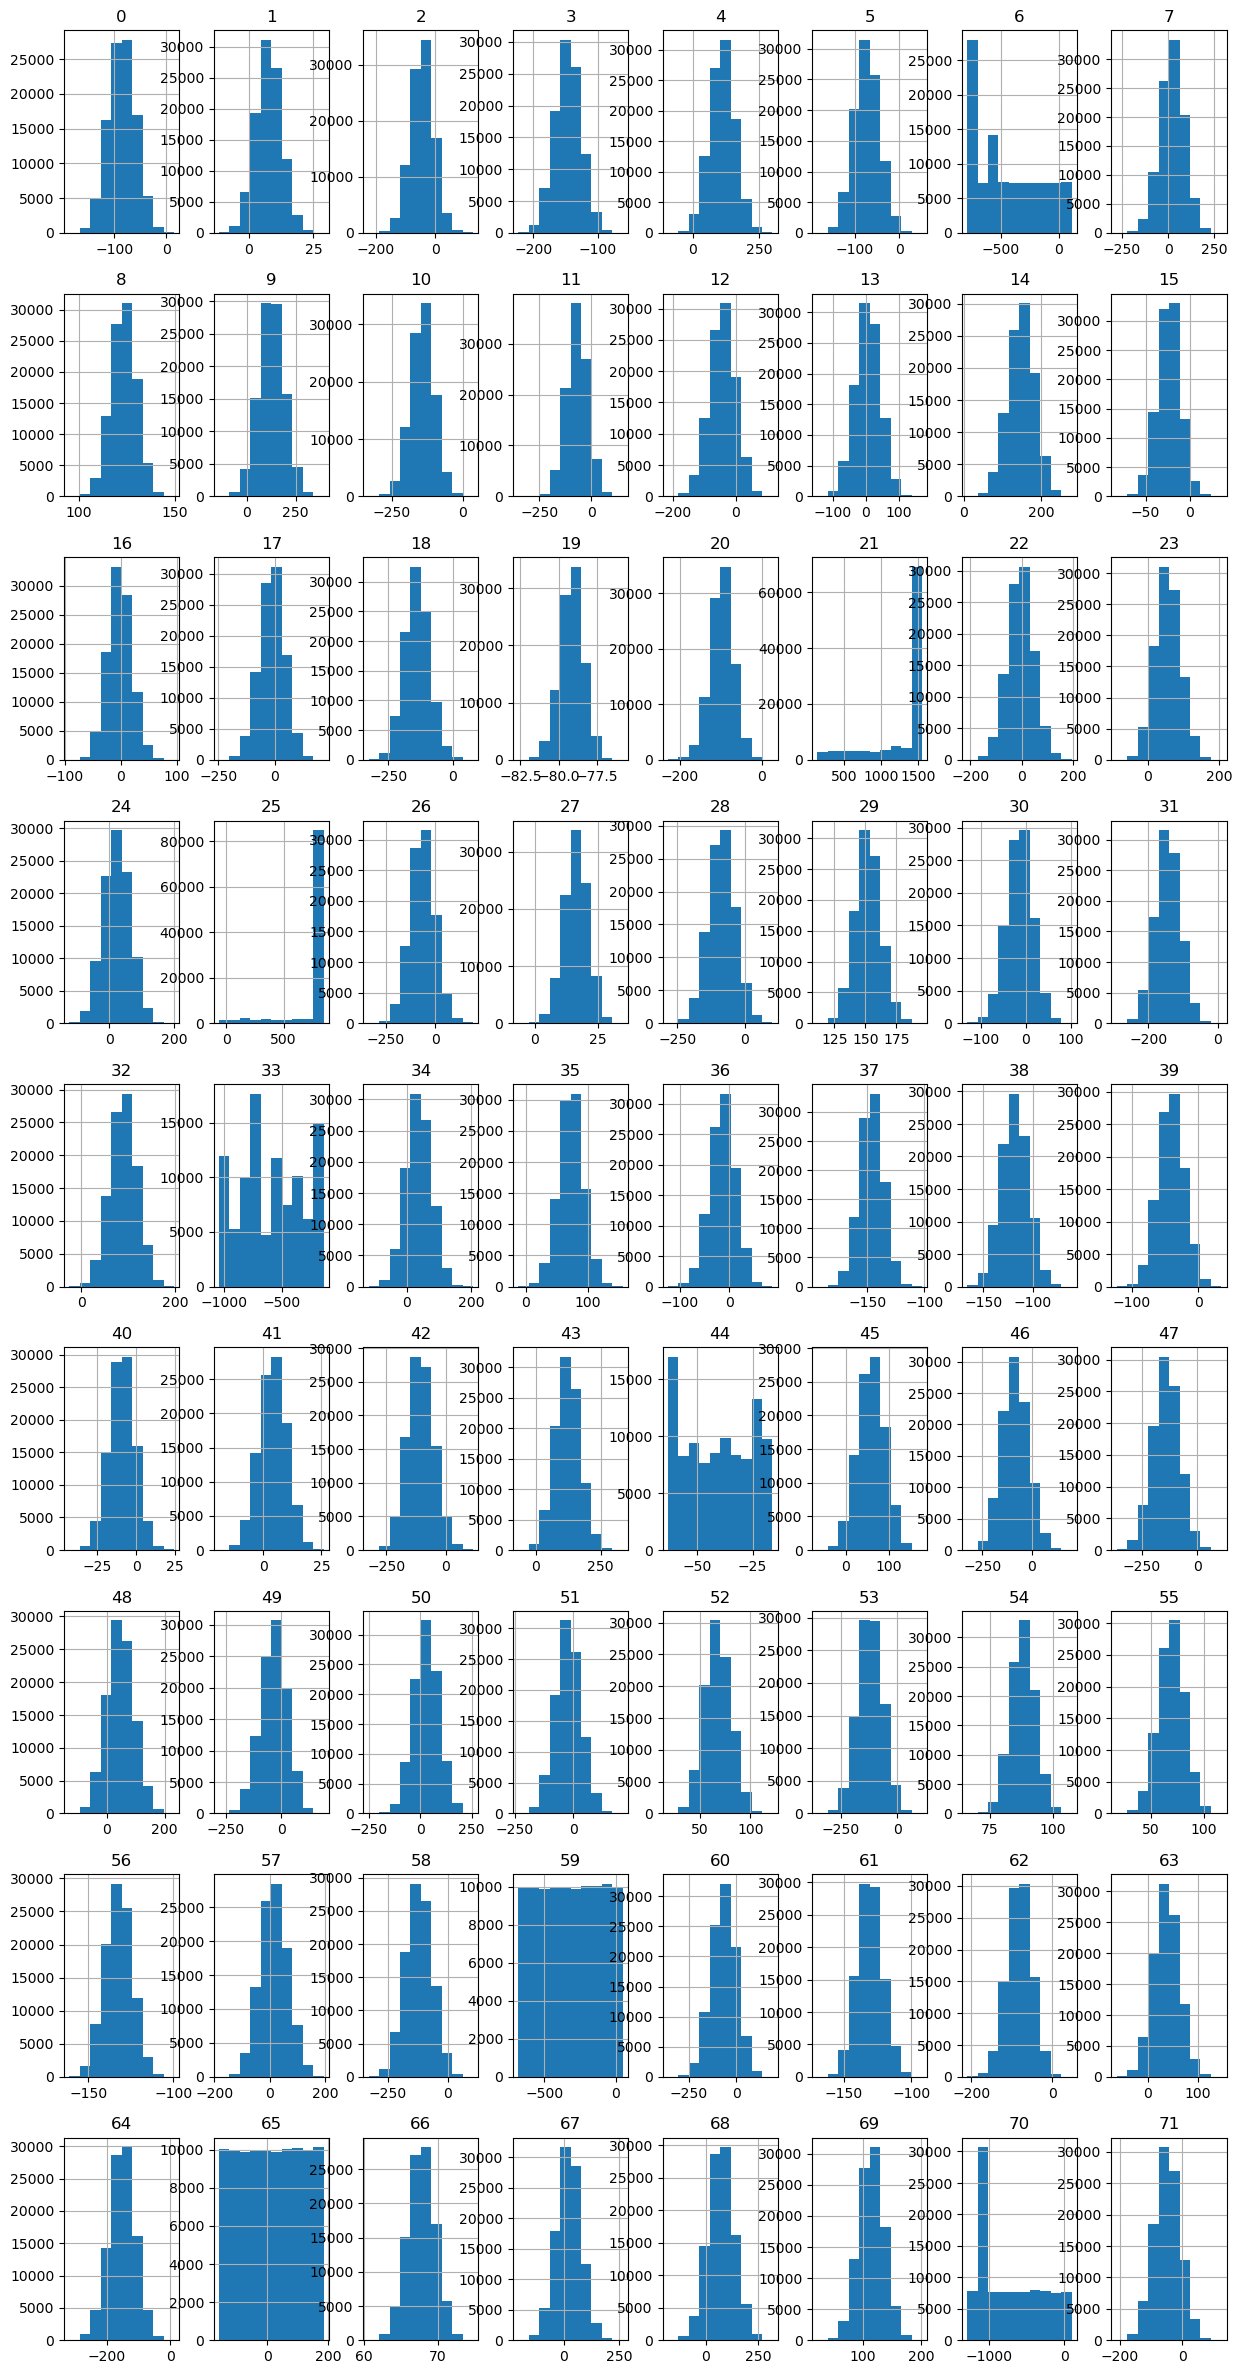

In [13]:
data_train.hist(figsize=(15, 30));

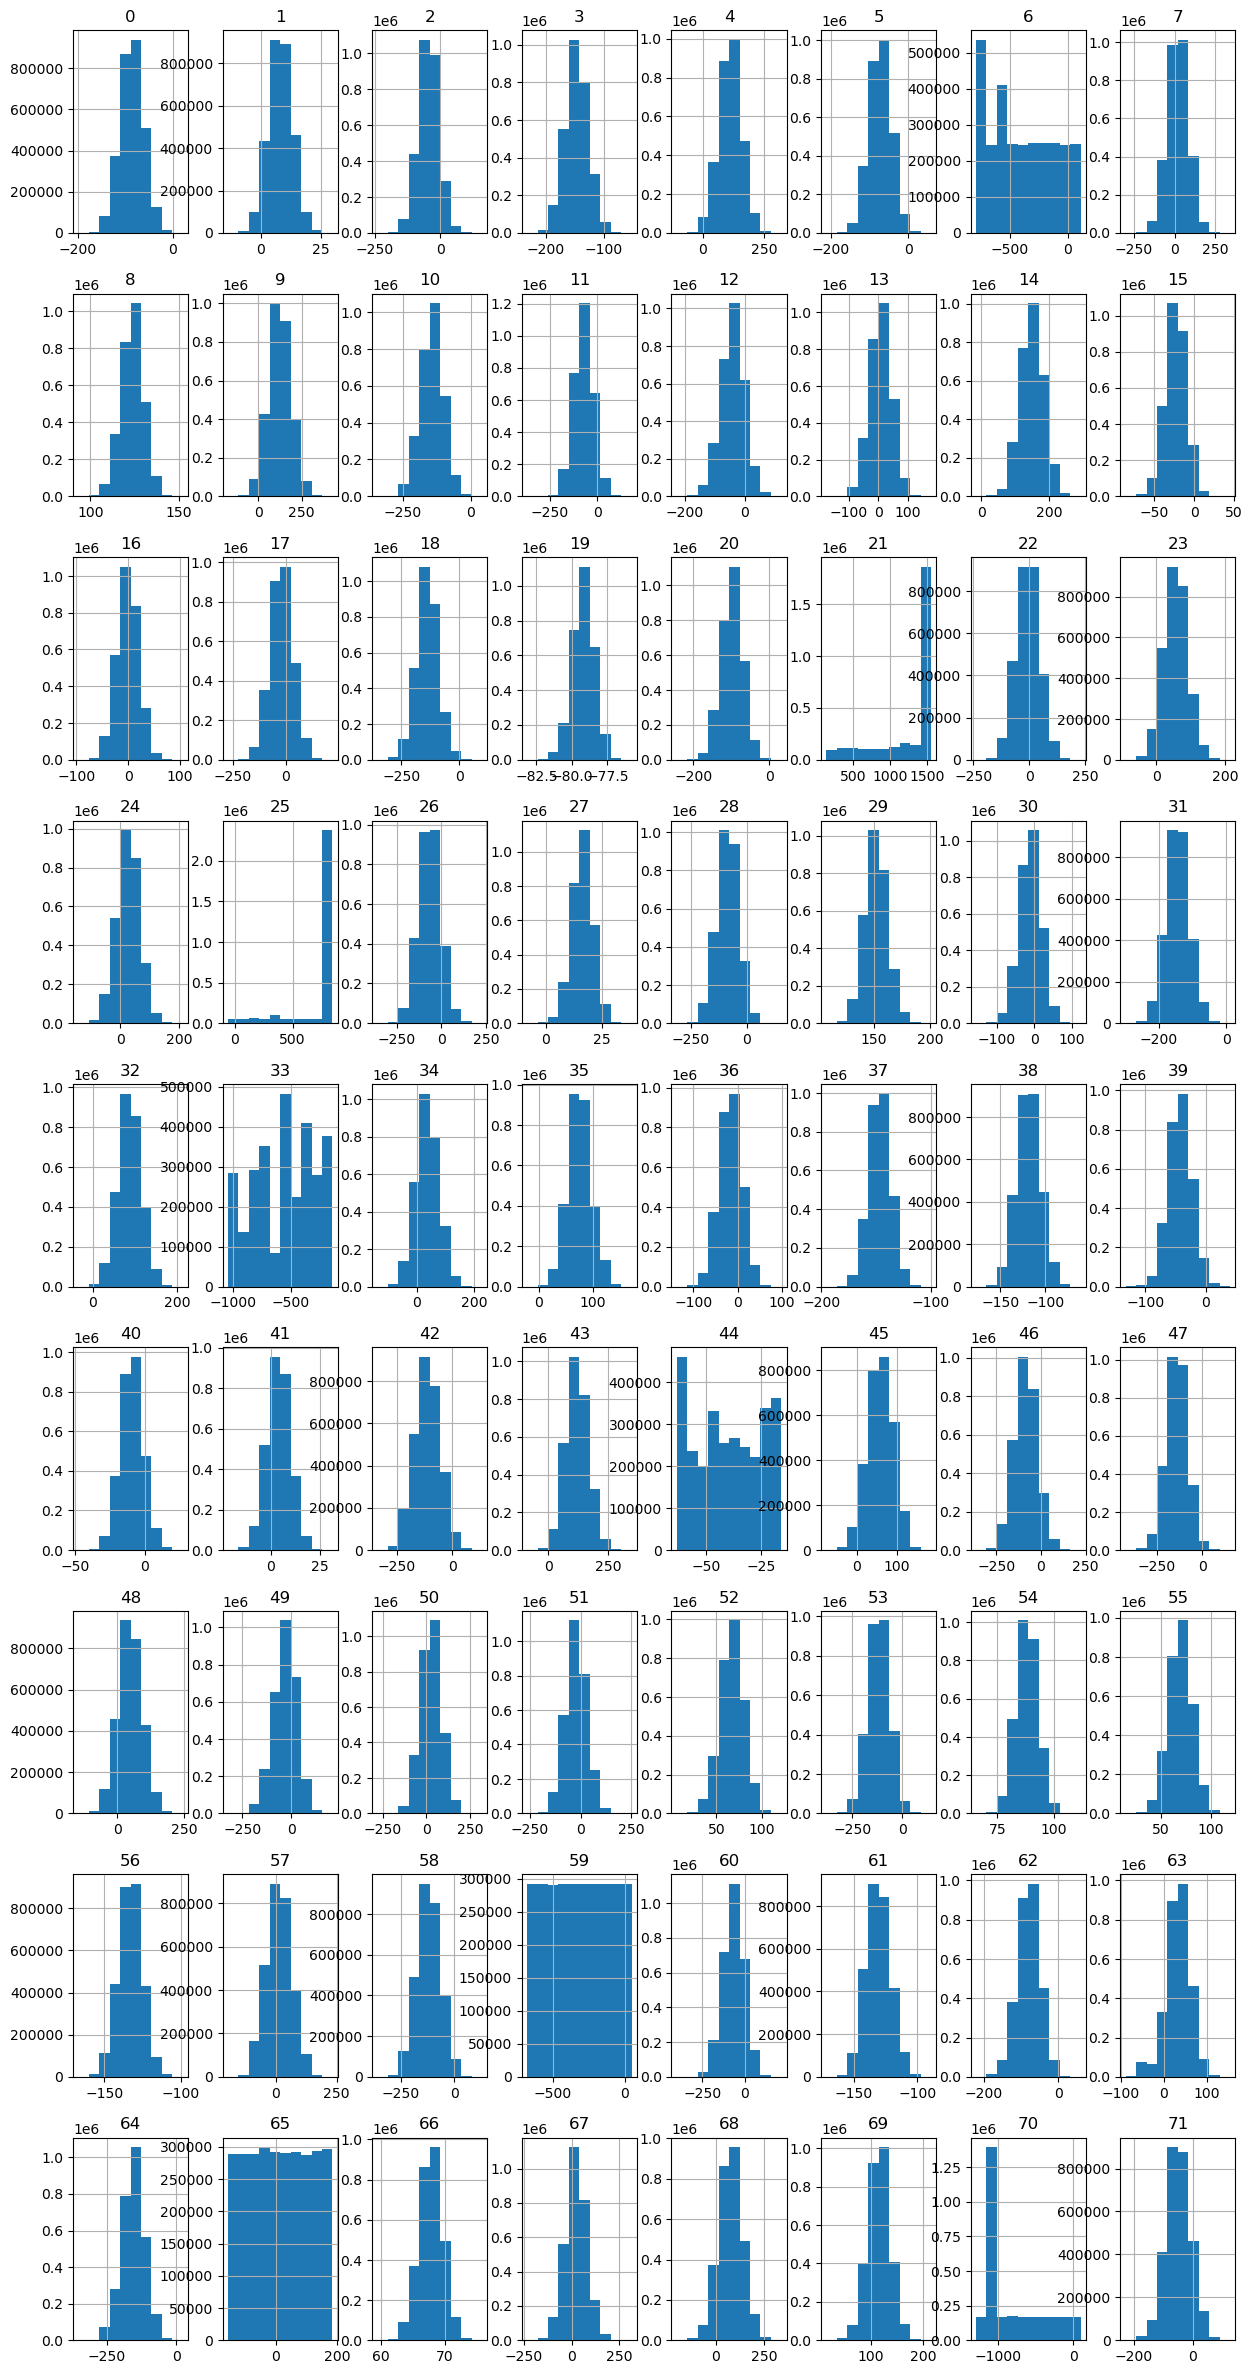

In [14]:
data_base.hist(figsize=(15, 30));

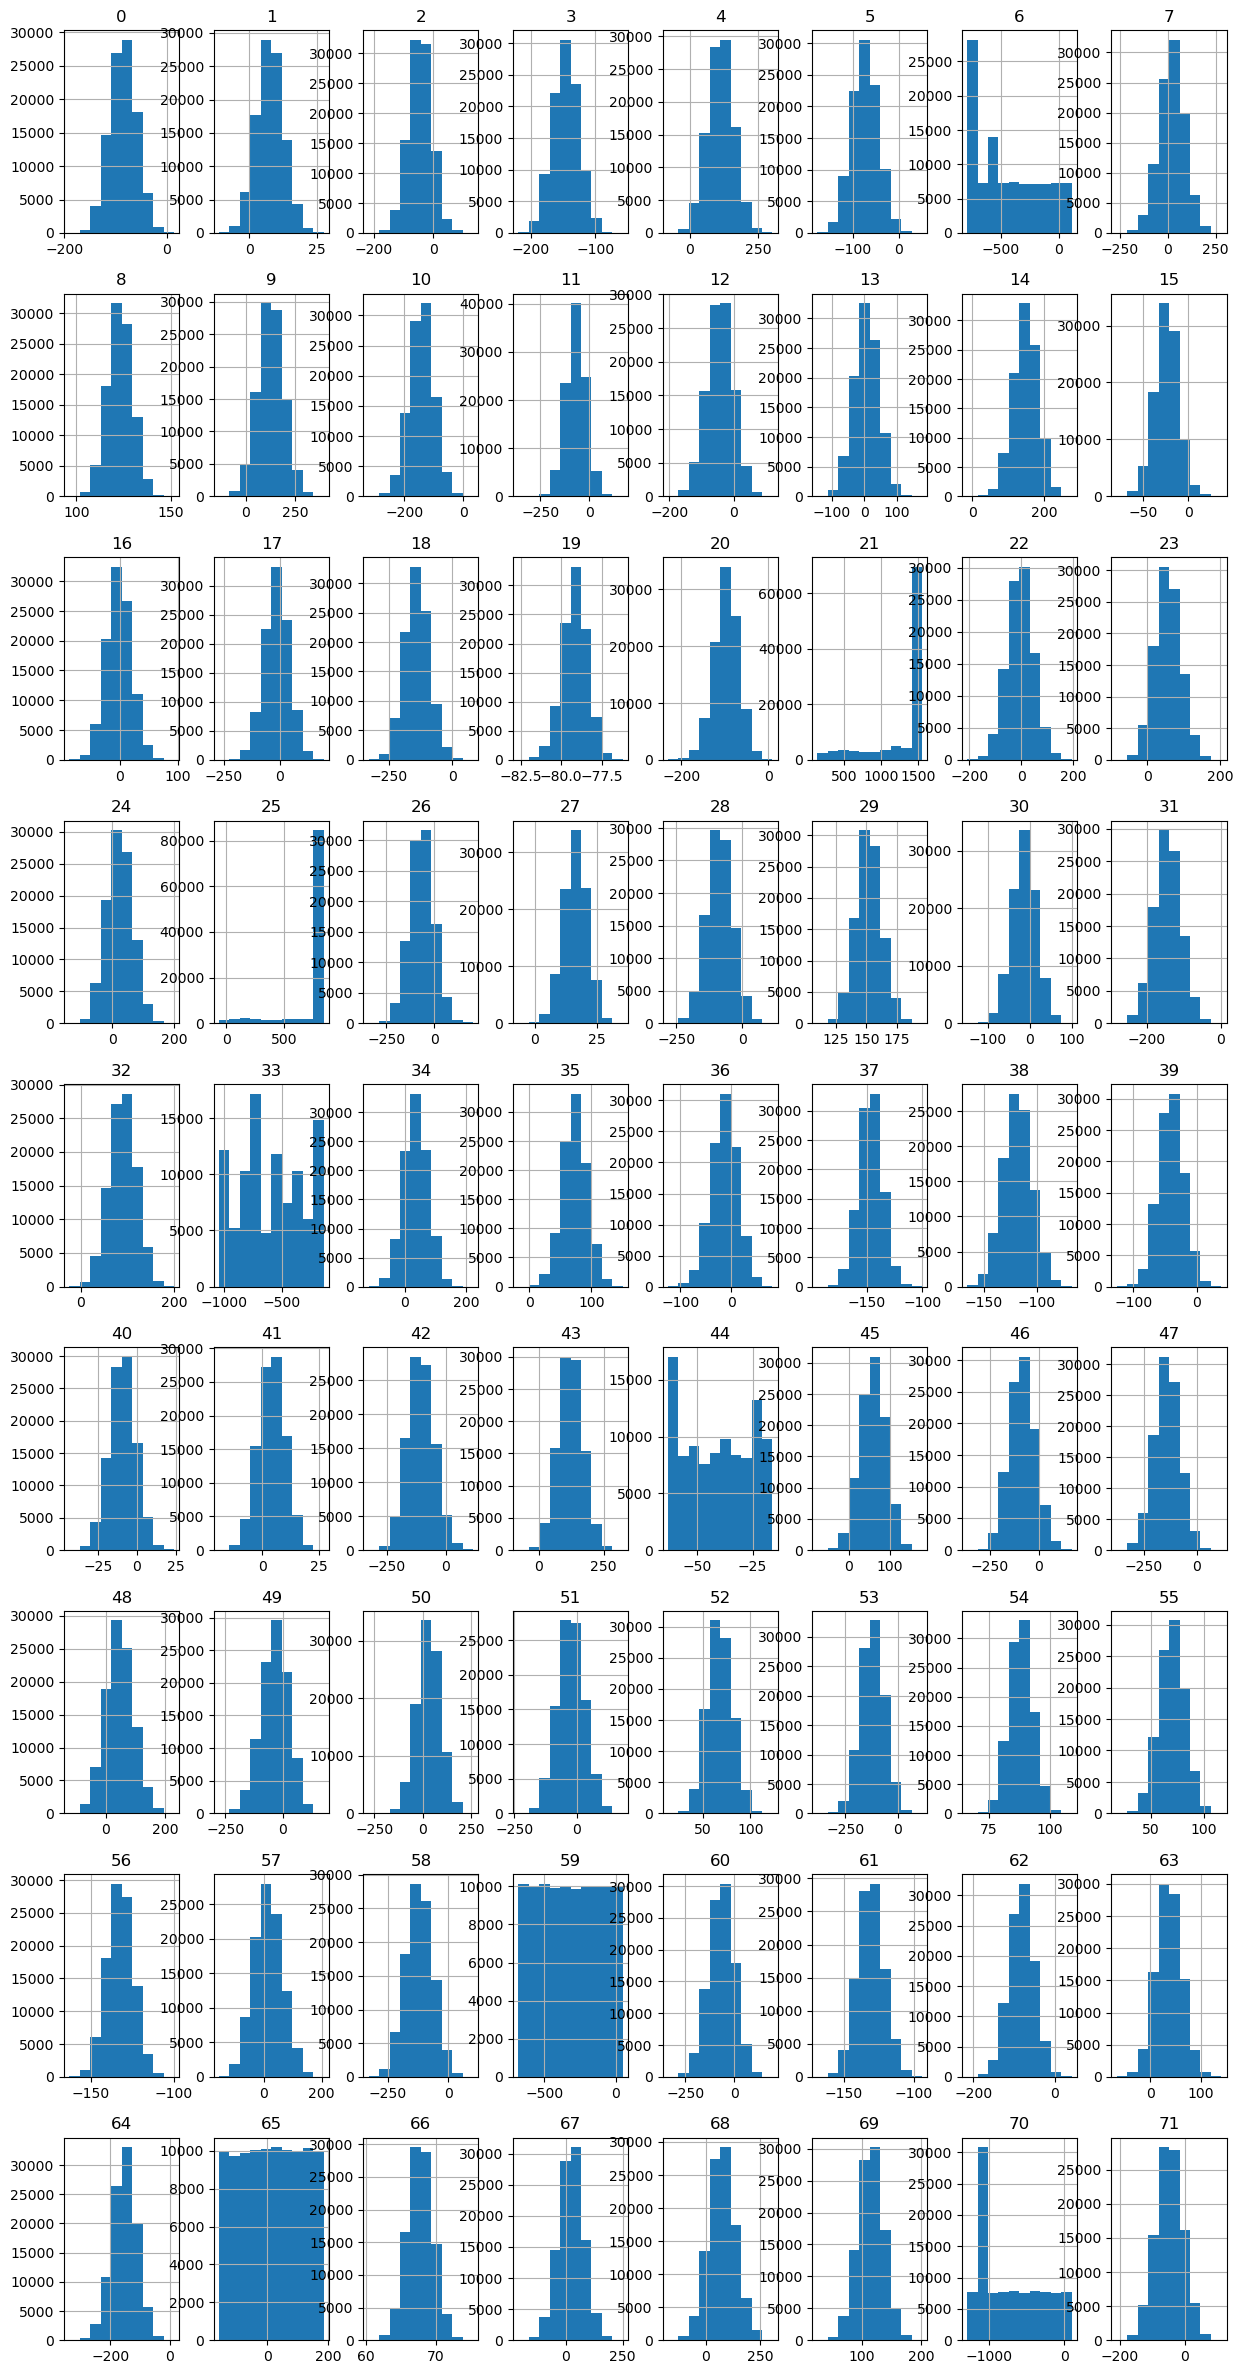

In [15]:
data_validation.hist(figsize=(15, 30));

Выведем значение кореляции данных.

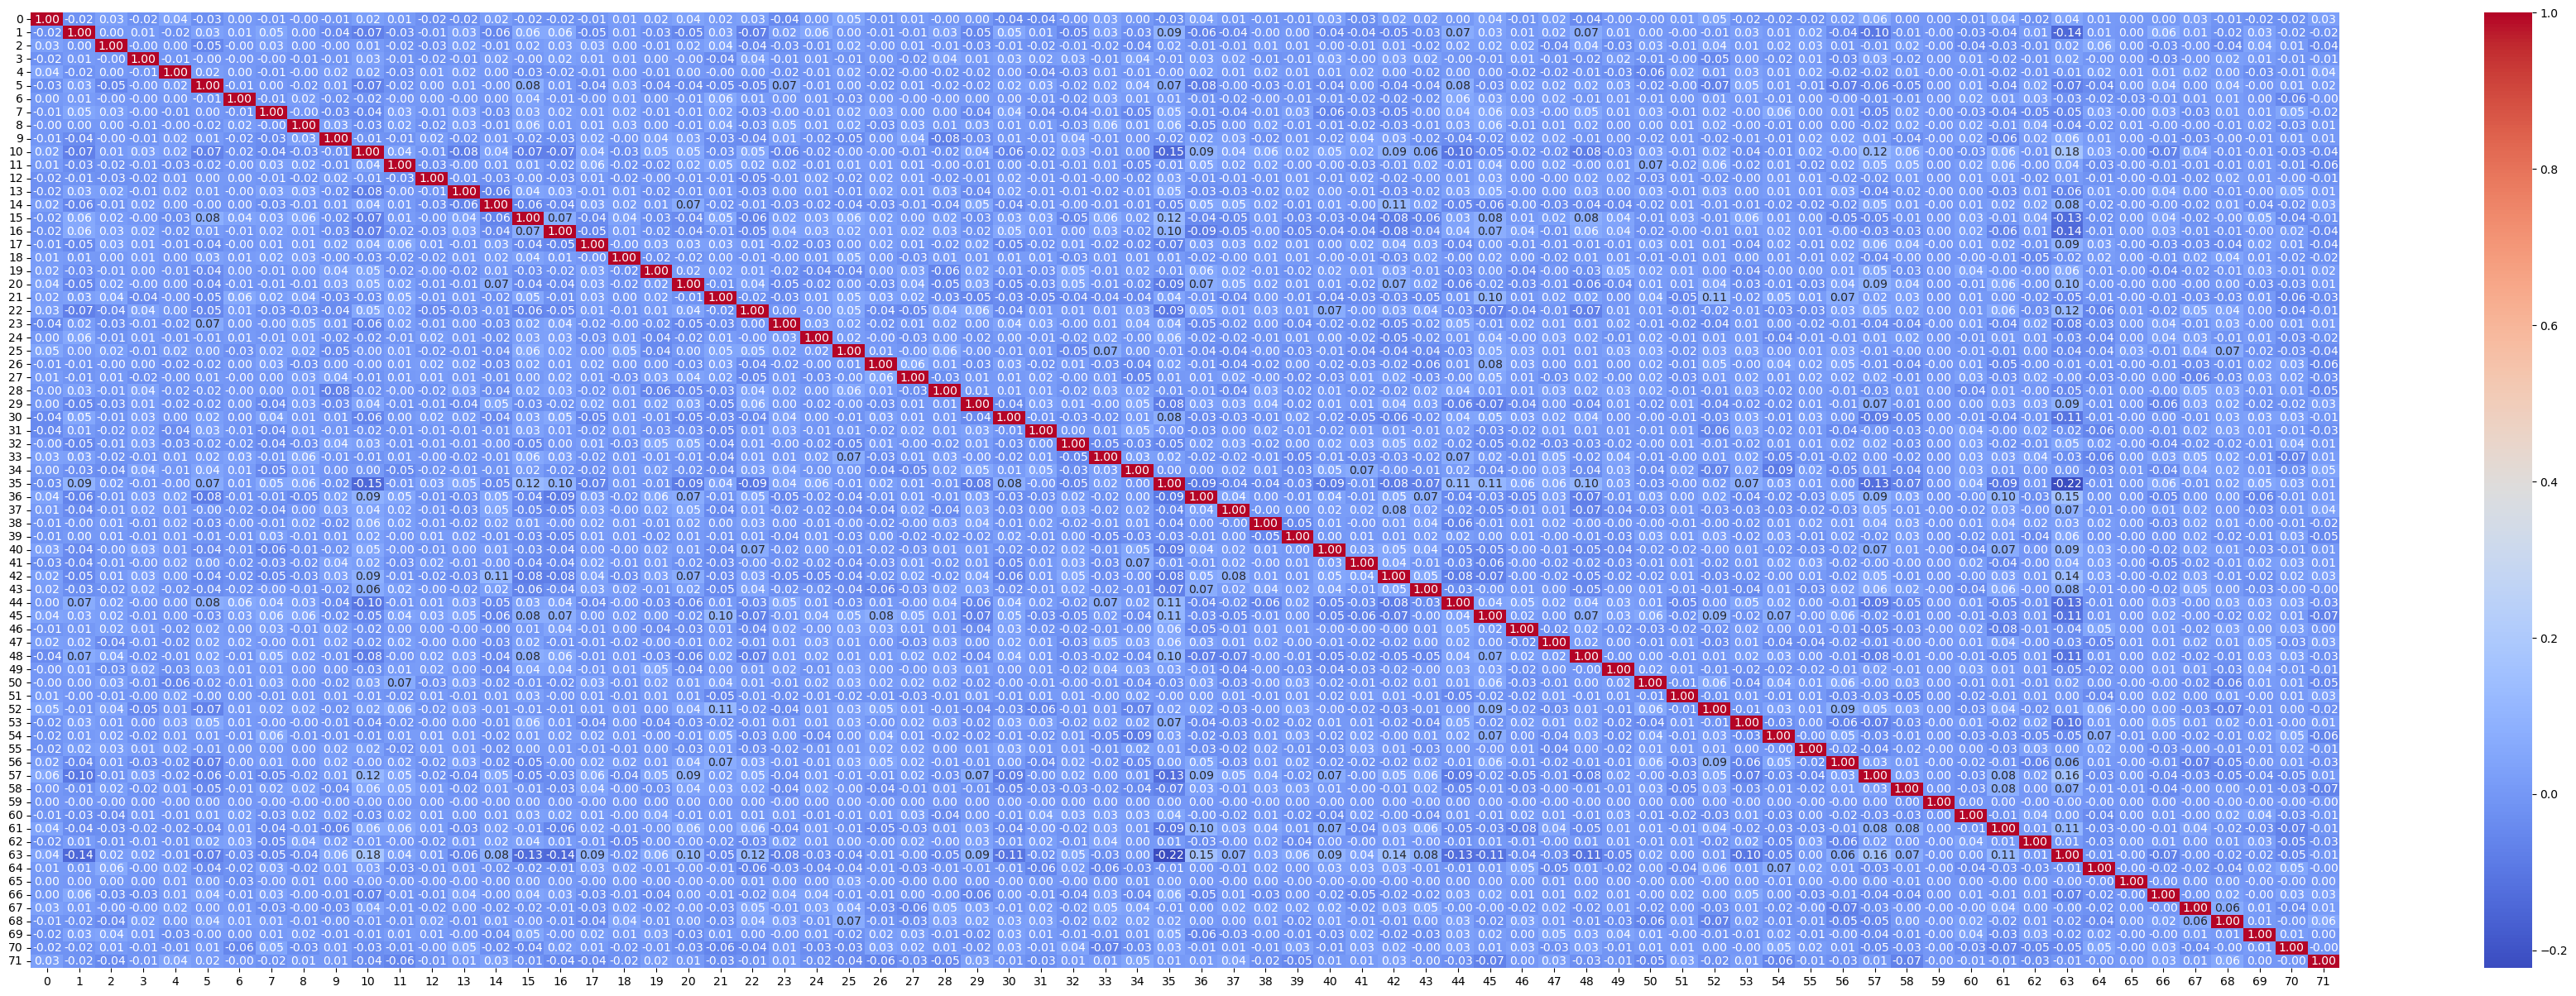

In [17]:
correlation_matrix = data_base.corr()
plt.figure(figsize=(45, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

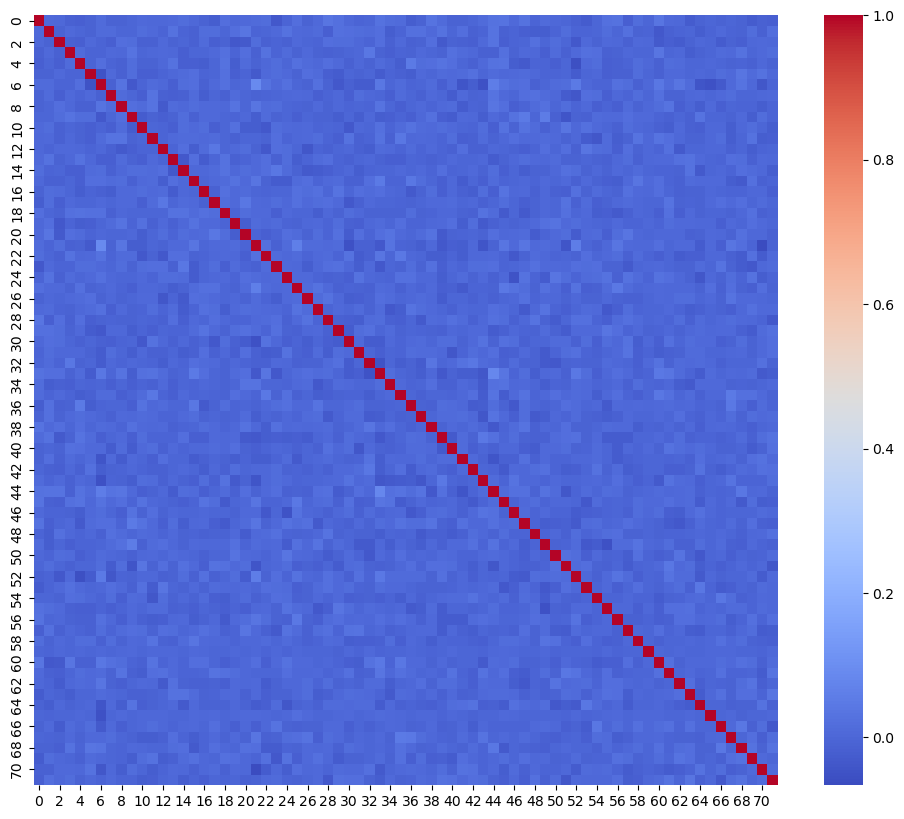

In [18]:
correlation_matrix = data_train.drop(columns=['target'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

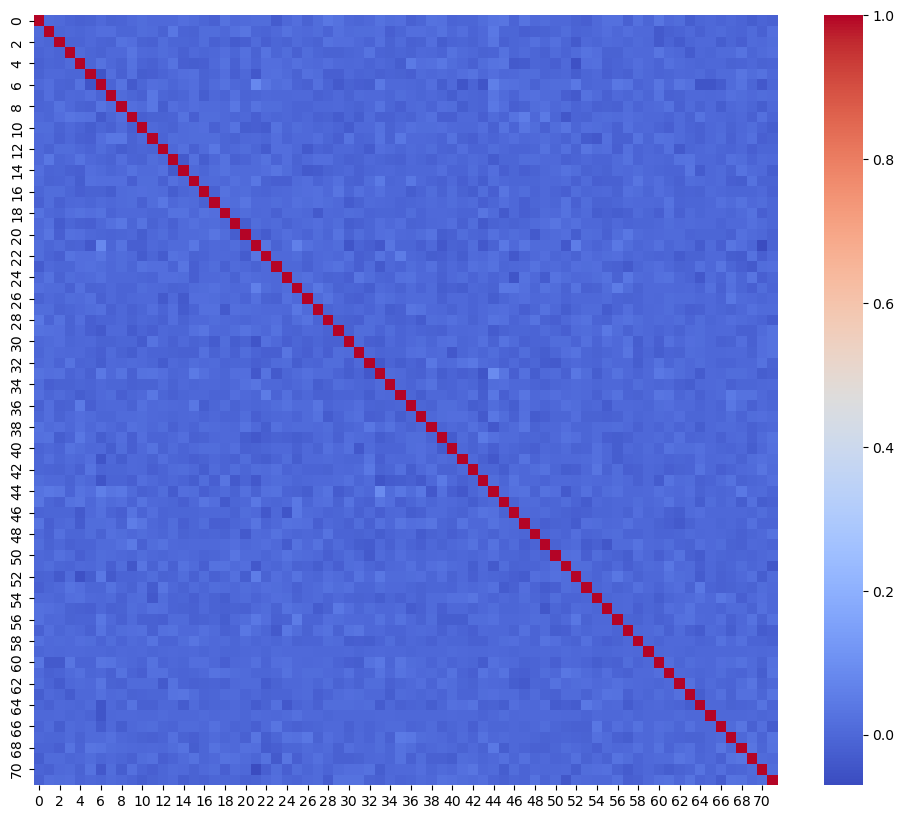

In [19]:
correlation_matrix = data_validation.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()

При изучении данных было принято решение удалить некоторые столбцы по следущим причинам:
1) равномерное распределение данных, что может негативно сказаться на обучении модели.
2) есть признаки, кореляция которых выделяется из общей массы, удалим их.

Опытным путем было проверено, что удаление данных признаков положительно сказалось на метрике.

In [20]:
data_base = data_base.drop(columns=['6', '21', '25', '33', '44', '59', '65', '70', '35'], axis=1)

In [21]:
data_train = data_train.drop(columns=['6', '21', '25', '33', '44', '59', '65', '70', '35'], axis=1)

In [22]:
data_validation = data_validation.drop(columns=['6', '21', '25', '33', '44', '59', '65', '70', '35'], axis=1)

После изучения данных мы можем сказать следующее:
1) все наборы данных зашифрованы, но это не должно негативно сказаться на работе модели поиска ближайих соседей.
2) пропуски отсутствуют
3) явные дупликаты отсутствуют
4) колирируюшие данные отсутствуют

Были удалены некоторые признаки.\
В цулом мы имеем очень качественные данные, которые позволят нам добиться хорошего результата.

##  Подготовка данных.

Формула расчет расстояний очень чувствительна к диапазону значений, предварительно проведем масштабирование признаков.

Создадим переменные, которые будет содержать перечень признаков,  а так же целевой признак. 

In [23]:
train_targets = data_train['target']
data_train.drop('target', axis=1, inplace=True)

StandardScaler преобразует данные в 2-умерный мессив и что бы нам не потерять уникальные индексы, создадим словарь где key - порядковый номер, а value - id.

In [24]:
# словарь id и номеров векторов
base_index = {k: v for k, v in enumerate(data_base.index.to_list())}

print('Пример содержания словаря:\n', list(base_index.items())[0:3])

Пример содержания словаря:
 [(0, '0-base'), (1, '1-base'), (2, '2-base')]


Произведем масштабирование данных

In [25]:
scaler = StandardScaler()

In [26]:
scaler.fit(data_base)

C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


StandardScaler()

In [27]:
data_base_standalize = scaler.transform(data_base)

C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [28]:
data_base_standalize

array([[-1.15921621,  0.62035039, -0.51372266, ...,  0.29300367,
        -0.0140507 , -0.31232868],
       [ 2.07571479,  1.06042331, -0.65249099, ...,  1.71128272,
         0.05984761, -0.28105191],
       [ 1.2854173 , -0.34334213,  0.39787757, ...,  0.09966891,
         0.04852086,  0.36562327],
       ...,
       [-0.43377605, -2.06403506, -0.69096928, ..., -0.09665779,
         0.65973154,  1.25777364],
       [-0.02446461,  0.16793925,  0.25220423, ...,  0.31775314,
         0.43807345, -0.19157949],
       [-0.63218019,  0.96487998, -0.17634065, ...,  0.15518477,
        -1.07356491,  1.49865842]])

In [29]:
data_train_standalize = scaler.transform(data_train)

C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [30]:
data_train_standalize

array([[ 1.29951853,  1.99688841,  0.06377414, ..., -0.20078586,
         0.90657478,  0.5229633 ],
       [-0.06214603, -0.25715933,  0.32424857, ...,  0.24477424,
         0.70945863, -0.08349097],
       [ 1.45632755, -0.85569567, -1.85179199, ...,  2.2406136 ,
         0.30057615,  0.60467723],
       ...,
       [ 1.29688741, -0.67694915,  0.39609629, ..., -0.6385802 ,
        -0.18653943,  1.04246115],
       [ 0.35786391,  0.41189884, -0.50254729, ..., -0.29439392,
        -0.22969231, -0.75940653],
       [-0.11325181,  0.57708342, -0.22327294, ...,  0.89708931,
        -0.70412654, -0.77516644]])

In [31]:
data_validation_standalize = scaler.transform(data_validation)

C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [32]:
data_validation_standalize

array([[ 1.15930954, -0.90490133,  0.81195496, ...,  0.59716736,
        -0.02012073, -1.6596744 ],
       [ 1.30450191,  0.95090974,  0.03396855, ...,  0.36054871,
         0.36953282,  0.54570096],
       [ 0.88602704, -2.43490095,  0.95521554, ...,  1.02171513,
         1.20494439, -0.55519655],
       ...,
       [ 1.08491737,  1.11151463,  1.74043576, ..., -1.80853797,
        -0.83314174,  0.47211983],
       [ 2.12426875,  0.72500447,  0.33658918, ..., -1.83498435,
         1.60762999, -0.31454979],
       [ 1.82681842, -0.2518207 ,  0.37760125, ...,  1.64641451,
         0.72920391,  0.34907994]])

На данном этапе мы произвели мастабирование данных, посмотрим как данный фаукт скажется на обучении модели. 

# Поиск ближайших соседей

Faiss (Facebook AI Similarity Search) - это библиотека для выполнения высокопроизводительного поиска ближайших соседей в больших наборах данных. Основной принцип работы Faiss включает в себя следующие шаги:

1) Индексирование данных: В первую очередь, данные индексируются. Это означает, что они структурируются и организуются таким образом, чтобы облегчить поиск ближайших соседей. Faiss предоставляет несколько типов индексов, таких как IVF (Inverted File), HNSW (Hierarchical Navigable Small World) и другие, для различных типов данных и задач.

2) Обучение индекса (опционально): Некоторые индексы Faiss, такие как IVF, могут быть обучены на обучающих данных. Обучение позволяет настроить индекс для конкретных данных и задач, учитывая их структуру и характеристики.

3) Поиск ближайших соседей: После индексации данных вы можете выполнять операции поиска ближайших соседей. Для этого вы передаете запрос (вектор) индексу, и Faiss ищет ближайшие объекты в индексированных данных. Метрика (расстояние) используется для измерения сходства между запросом и данными.

4) Оптимизация параметров: Faiss предоставляет параметры, которые можно настроить, такие как количество ячеек для поиска (nprobe), тип квантования, метрика, размерность и другие. Настройка этих параметров позволяет оптимизировать производительность и точность поиска.

5) Возврат результатов поиска: Faiss возвращает результаты поиска, которые могут включать в себя идентификаторы ближайших соседей, расстояния до них и, при необходимости, дополнительные метаданные.

6) Анализ результатов: Важно анализировать результаты поиска, чтобы понять, насколько хорошо индекс работает для конкретных данных и задач. Это может включать в себя оценку точности и производительности.

Преимущество Faiss заключается в его высокой производительности и масштабируемости, что делает его подходящим для поиска ближайших соседей в больших объемах данных, таких как изображения, векторы признаков, текстовые данные и многое другое. Faiss также предоставляет различные типы индексов и параметры, что позволяет адаптировать его под разнообразные задачи и типы данных.

Проиндексируем данные.

In [48]:
dims = data_base_standalize.shape[1] 
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, CLUSTERS)

In [49]:
# обучение делителя пространства на первых 50 тысячах объектов из df_base
idx_l2.train(np.ascontiguousarray(data_base_standalize[:50000, :]).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(data_base_standalize).astype('float32'))

Произведем поиск соседей из train_data для товаров из base_data

In [56]:
%%time

nprobe = 100
idx_l2.nprobe = nprobe

vectors, train_idx = idx_l2.search(np.ascontiguousarray(data_train_standalize).astype('float32'), NEIGHBORS)

print('Примеры train_idx :\n', train_idx[:3], '\n')
print('Примеры vectors :\n', vectors[:3])
del vectors

Примеры train_idx :
 [[ 336969 1113711 1818641  480296  232405]
 [  15185  519311  737853  223456 2524968]
 [1162532  173120 1784963  137853 2475151]] 

Примеры vectors :
 [[10.014105  10.948144  11.300769  12.110563  12.125921 ]
 [11.1098795 13.367466  17.600624  22.646631  22.646631 ]
 [14.638702  15.533059  16.37838   16.4268    18.14265  ]]
CPU times: total: 4h 48min 21s
Wall time: 19min


Расчитаем метрику и распечатаем ее. Для этого создадим специальную функцию.

In [57]:
# функция вычисления accuracy@n
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)

In [58]:
print('accuracy@{}: {:.2f}%'.format(K_NEIGHBORS, accuracy_n(train_targets, train_idx)))

accuracy@5: 71.02%


Произведем поиск соседей из validation_data для товаров из base_data

In [59]:
%%time

vectors, valid_idx = idx_l2.search(np.ascontiguousarray(data_validation_standalize).astype('float32'), NEIGHBORS)

print('Примеры train_idx :\n', train_idx[:3], '\n')
print('Примеры vectors :\n', vectors[:3])
del vectors

Примеры train_idx :
 [[ 336969 1113711 1818641  480296  232405]
 [  15185  519311  737853  223456 2524968]
 [1162532  173120 1784963  137853 2475151]] 

Примеры vectors :
 [[5.4830275e+00 5.7055182e+00 6.8962250e+00 7.2522564e+00 7.6926808e+00]
 [1.9378639e+01 2.1909170e+01 2.2385464e+01 2.4218813e+01 2.8500181e+01]
 [4.2016973e-07 1.0337765e+01 1.0611910e+01 1.1827380e+01 1.9438465e+01]]
CPU times: total: 4h 38min 7s
Wall time: 18min 27s


Расчитаем метрику и распечатаем ее

In [75]:
print('accuracy@{}: {:.2f}%'.format(K_NEIGHBORS, accuracy_n(data_validation_answer['expected'], valid_idx)))

accuracy@5: 70.93%


Нами были получены индексы соседей иметрика показыает не плохое качество поиска, нами были применена IndexIVFFlat индексация, так же мы разбили данные на кластеры, указали количество необходимых соседей. Мною были перебраны все методы индексации и именно IndexIVFFlat показал самую лучшую метрику. 

Повысить качество метрики нам удалось после удаления признаков, указанных выше, так же было установлено количество количество ячеек для поиска - nprobe,  это параметр в библиотеке Faiss, который определяет сколько кластеров (ячеек) индекс будет проверять при поиске ближайших соседей. Мною было практически найдено оптимальное значение, ладбнейшее увеличение ячеек не увеличивает метрику. 

Так же практически получилось выяснить, что Faiss критически относится к распределению данных, а так же к кореляции, мною были удалены все значения, кореляция которых выделялась из обшей массы, что положительно сказалось на метрике. 

Приступим к ранжированию данных обучени модели.

### Формирование тренировочной выборки

Первым делом необходимо составить новый датафрейм состоящий из двух половин:
1. Искомые векторы
2. Несколько кандидатов на сопоставление для каждого искомого вектора.

Подготовим датафрейм с перечнем ID новых и старых объектов

In [62]:
idx_df = pd.DataFrame(data=train_idx, index=data_train.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

display(idx_df.head(5))

,id_query,id_candidate
0,0-query,361564-base
1,0-query,1375561-base
2,0-query,2515747-base
3,0-query,530165-base
4,0-query,244376-base


Сформируем датафреймы из масштабированных данных и объединеним base и train по заготовленным id

In [63]:
data_base_standalize  = pd.DataFrame(data_base_standalize,  index=data_base.index)
data_train_standalize = pd.DataFrame(data_train_standalize, index=data_train.index)
data_validation_standalize = pd.DataFrame(data_validation_standalize, index=data_validation.index)

train_base_data = idx_df.merge(data_train_standalize, left_on='id_query', right_on='id', how='left')
train_base_data = train_base_data.merge(data_base_standalize, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
train_base_data = train_base_data.merge(train_targets, left_on='id_query', right_on='id', how='left')
display(train_base_data.head(10))

,id_query,id_candidate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,0_base,1_base,2_base,3_base,4_base,5_base,6_base,7_base,8_base,9_base,10_base,11_base,12_base,13_base,14_base,15_base,16_base,17_base,18_base,19_base,20_base,21_base,22_base,23_base,24_base,25_base,26_base,27_base,28_base,29_base,30_base,31_base,32_base,33_base,34_base,35_base,36_base,37_base,38_base,39_base,40_base,41_base,42_base,43_base,44_base,45_base,46_base,47_base,48_base,49_base,50_base,51_base,52_base,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,target
0,0-query,361564-base,1.29952,1.99689,0.06377,-1.87967,1.64410,-0.53763,0.27960,-2.29679,-1.45963,1.32071,0.33563,0.34834,-0.07418,1.46758,-0.52833,-0.13762,-2.19922,-0.52697,0.89398,0.13583,-1.21825,0.63289,2.08870,-0.13875,-0.79563,-2.00867,-0.20007,-0.53314,0.31707,0.68930,0.31311,1.57564,-0.46033,1.08261,0.38476,-0.37906,-0.24466,-0.14447,0.62342,0.72798,-0.48963,-1.81578,-0.91381,-1.71248,0.71461,-0.33031,-0.31055,-0.26975,0.24314,1.49261,1.48757,-0.39572,-1.57330,-0.19343,-0.17958,-0.86698,1.27432,-0.02441,-1.03539,0.19718,-0.20079,0.90657,0.52296,1.04486,1.88467,-0.00785,-2.04889,1.42315,-0.28190,0.46491,-1.75127,-0.70784,0.71863,0.29492,0.37248,0.15038,1.96216,0.18488,-0.19672,-2.70541,-1.18091,0.42604,0.23613,-0.91023,0.46446,1.38915,-0.05926,-0.17792,-1.51761,-0.43799,-0.61243,1.00246,0.30110,0.49996,1.74473,-0.26287,1.05150,0.36742,-0.54877,0.07878,0.43001,0.84579,0.91200,-0.25407,-0.72501,-0.83618,-1.92636,0.29810,0.25059,-0.19570,-0.84431,0.15650,1.23022,1.52939,0.11971,-1.99745,0.41404,0.21662,-0.33215,1.72339,-0.36946,-1.10024,0.28092,-0.49204,0.53210,0.09028,675816-base
1,0-query,1375561-base,1.29952,1.99689,0.06377,-1.87967,1.64410,-0.53763,0.27960,-2.29679,-1.45963,1.32071,0.33563,0.34834,-0.07418,1.46758,-0.52833,-0.13762,-2.19922,-0.52697,0.89398,0.13583,-1.21825,0.63289,2.08870,-0.13875,-0.79563,-2.00867,-0.20007,-0.53314,0.31707,0.68930,0.31311,1.57564,-0.46033,1.08261,0.38476,-0.37906,-0.24466,-0.14447,0.62342,0.72798,-0.48963,-1.81578,-0.91381,-1.71248,0.71461,-0.33031,-0.31055,-0.26975,0.24314,1.49261,1.48757,-0.39572,-1.57330,-0.19343,-0.17958,-0.86698,1.27432,-0.02441,-1.03539,0.19718,-0.20079,0.90657,0.52296,1.11973,2.14563,-0.05185,-1.68710,1.03355,-0.30002,0.79672,-1.74204,-0.77547,0.78810,0.37459,0.37915,0.28406,1.85685,0.06594,-0.40775,-2.95167,-0.98992,0.36324,0.10125,-0.84771,0.35571,1.66054,-0.14004,-0.01997,-1.72105,-0.48740,-0.16200,1.04310,0.30230,0.47379,1.58878,-0.42194,0.97776,0.50936,-0.66944,0.34355,0.62718,0.70490,0.84035,-0.31251,-0.57917,-0.69413,-1.92401,0.14028,0.02530,0.01018,-0.79479,0.63870,1.79351,1.74708,-0.29477,-1.57686,0.68531,0.14449,-0.87315,1.69985,-0.24195,-0.98526,0.00902,-0.47514,0.47939,0.37149,675816-base
2,0-query,2515747-base,1.29952,1.99689,0.06377,-1.87967,1.64410,-0.53763,0.27960,-2.29679,-1.45963,1.32071,0.33563,0.34834,-0.07418,1.46758,-0.52833,-0.13762,-2.19922,-0.52697,0.89398,0.13583,-1.21825,0.63289,2.08870,-0.13875,-0.79563,-2.00867,-0.20007,-0.53314,0.31707,0.68930,0.31311,1.57564,-0.46033,1.08261,0.38476,-0.37906,-0.24466,-0.14447,0.62342,0.72798,-0.48963,-1.81578,-0.91381,-1.71248,0.71461,-0.33031,-0.31055,-0.26975,0.24314,1.49261,1.48757,-0.39572,-1.57330,-0.19343,-0.17958,-0.86698,1.27432,-0.02441,-1.03539,0.19718,-0.20079,0.90657,0.52296,0.68515,1.62662,-0.29421,-1.77043,1.17597,-0.44545,0.91470,-1.48103,-0.83919,0.86607,-0.04179,0.45593,-0.24466,2.19663,0.32008,-0.61656,-2.80722,-1.10942,0.73689,-0.40933,-0.99390,0.51493,1.31609,0.00513,-0.41388,-1.56653,-0.68340,-0.10227,0.84695,1.06784,0.68673,1.79125,-0.67021,1.25612,0.00734,-0.87589,0.32768,0.40969,0.13637,0.54178,-0.33734,-0.96474,-0.39347,-1.96891,0.45232,-0.16017,-0.19331,-0.86246,0.30182,2.02867,1.38719,-0.16041,-1.56770,0.36785,-0.22060,-0.67362,1.18206,-0.39343,-1.03962,0.07684,-0.35394,0.69807,0

Преобразуем целевой признак для бинарной классификации.

In [64]:
train_base_data['matching'] = (train_base_data['id_candidate'] == train_base_data['target']).astype('int')
display(train_base_data[['id_query', 'id_candidate', 'target', 'matching']])
train_base_data.drop('target', axis=1, inplace=True)

,id_query,id_candidate,target,matching
0,0-query,361564-base,675816-base,0
1,0-query,1375561-base,675816-base,0
2,0-query,2515747-base,675816-base,0
3,0-query,530165-base,675816-base,0
4,0-query,244376-base,675816-base,0
...,...,...,...,...
499995,99999-query,2769109-base,2769109-base,1
499996,99999-query,771164-base,2769109-base,0
499997,99999-query,1412044-base,2769109-base,0
499998,99999-query,3599061-base,2769109-base,0


Выделение признаков и таргета

In [65]:
y_train = train_base_data['matching']
X_train = train_base_data.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_train.to_frame())
display(X_train)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
499995,1
499996,0
499997,0
499998,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,0_base,1_base,2_base,3_base,4_base,5_base,6_base,7_base,8_base,9_base,10_base,11_base,12_base,13_base,14_base,15_base,16_base,17_base,18_base,19_base,20_base,21_base,22_base,23_base,24_base,25_base,26_base,27_base,28_base,29_base,30_base,31_base,32_base,33_base,34_base,35_base,36_base,37_base,38_base,39_base,40_base,41_base,42_base,43_base,44_base,45_base,46_base,47_base,48_base,49_base,50_base,51_base,52_base,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base
0,1.29952,1.99689,0.06377,-1.87967,1.64410,-0.53763,0.27960,-2.29679,-1.45963,1.32071,0.33563,0.34834,-0.07418,1.46758,-0.52833,-0.13762,-2.19922,-0.52697,0.89398,0.13583,-1.21825,0.63289,2.08870,-0.13875,-0.79563,-2.00867,-0.20007,-0.53314,0.31707,0.68930,0.31311,1.57564,-0.46033,1.08261,0.38476,-0.37906,-0.24466,-0.14447,0.62342,0.72798,-0.48963,-1.81578,-0.91381,-1.71248,0.71461,-0.33031,-0.31055,-0.26975,0.24314,1.49261,1.48757,-0.39572,-1.57330,-0.19343,-0.17958,-0.86698,1.27432,-0.02441,-1.03539,0.19718,-0.20079,0.90657,0.52296,1.04486,1.88467,-0.00785,-2.04889,1.42315,-0.28190,0.46491,-1.75127,-0.70784,0.71863,0.29492,0.37248,0.15038,1.96216,0.18488,-0.19672,-2.70541,-1.18091,0.42604,0.23613,-0.91023,0.46446,1.38915,-0.05926,-0.17792,-1.51761,-0.43799,-0.61243,1.00246,0.30110,0.49996,1.74473,-0.26287,1.05150,0.36742,-0.54877,0.07878,0.43001,0.84579,0.91200,-0.25407,-0.72501,-0.83618,-1.92636,0.29810,0.25059,-0.19570,-0.84431,0.15650,1.23022,1.52939,0.11971,-1.99745,0.41404,0.21662,-0.33215,1.72339,-0.36946,-1.10024,0.28092,-0.49204,0.53210,0.09028
1,1.29952,1.99689,0.06377,-1.87967,1.64410,-0.53763,0.27960,-2.29679,-1.45963,1.32071,0.33563,0.34834,-0.07418,1.46758,-0.52833,-0.13762,-2.19922,-0.52697,0.89398,0.13583,-1.21825,0.63289,2.08870,-0.13875,-0.79563,-2.00867,-0.20007,-0.53314,0.31707,0.68930,0.31311,1.57564,-0.46033,1.08261,0.38476,-0.37906,-0.24466,-0.14447,0.62342,0.72798,-0.48963,-1.81578,-0.91381,-1.71248,0.71461,-0.33031,-0.31055,-0.26975,0.24314,1.49261,1.48757,-0.39572,-1.57330,-0.19343,-0.17958,-0.86698,1.27432,-0.02441,-1.03539,0.19718,-0.20079,0.90657,0.52296,1.11973,2.14563,-0.05185,-1.68710,1.03355,-0.30002,0.79672,-1.74204,-0.77547,0.78810,0.37459,0.37915,0.28406,1.85685,0.06594,-0.40775,-2.95167,-0.98992,0.36324,0.10125,-0.84771,0.35571,1.66054,-0.14004,-0.01997,-1.72105,-0.48740,-0.16200,1.04310,0.30230,0.47379,1.58878,-0.42194,0.97776,0.50936,-0.66944,0.34355,0.62718,0.70490,0.84035,-0.31251,-0.57917,-0.69413,-1.92401,0.14028,0.02530,0.01018,-0.79479,0.63870,1.79351,1.74708,-0.29477,-1.57686,0.68531,0.14449,-0.87315,1.69985,-0.24195,-0.98526,0.00902,-0.47514,0.47939,0.37149
2,1.29952,1.99689,0.06377,-1.87967,1.64410,-0.53763,0.27960,-2.29679,-1.45963,1.32071,0.33563,0.34834,-0.07418,1.46758,-0.52833,-0.13762,-2.19922,-0.52697,0.89398,0.13583,-1.21825,0.63289,2.08870,-0.13875,-0.79563,-2.00867,-0.20007,-0.53314,0.31707,0.68930,0.31311,1.57564,-0.46033,1.08261,0.38476,-0.37906,-0.24466,-0.14447,0.62342,0.72798,-0.48963,-1.81578,-0.91381,-1.71248,0.71461,-0.33031,-0.31055,-0.26975,0.24314,1.49261,1.48757,-0.39572,-1.57330,-0.19343,-0.17958,-0.86698,1.27432,-0.02441,-1.03539,0.19718,-0.20079,0.90657,0.52296,0.68515,1.62662,-0.29421,-1.77043,1.17597,-0.44545,0.91470,-1.48103,-0.83919,0.86607,-0.04179,0.45593,-0.24466,2.19663,0.32008,-0.61656,-2.80722,-1.10942,0.73689,-0.40933,-0.99390,0.51493,1.31609,0.00513,-0.41388,-1.56653,-0.68340,-0.10227,0.84695,1.06784,0.68673,1.79125,-0.67021,1.25612,0.00734,-0.87589,0.32768,0.40969,0.13637,0.54178,-0.33734,-0.96474,-0.39347,-1.96891,0.45232,-0.16017,-0.19331,-0.86246,0.30182,2.02867,1.38719,-0.16041,-1.56770,0.36785,-0.22060,-0.67362,1.18206,-0.39343,-1.03962,0.07684,-0.35394,0.69807,0.92002
3,1.29952,1.99689,0.06377,-1.87967,1.64410,-0.53763,0.27960,-2.29679,-1.45963,1.32071,0.33563,0.34834,-0.074

## Формирование валидационной выборки

Проделаем все предыдущие операции для валидационной выборки.

In [66]:
%%time
vectors, valid_idx = idx_l2.search(np.ascontiguousarray(data_validation_standalize), NEIGHBORS)

print('Примеры idx :\n', valid_idx[:3], '\n')
print('accuracy@{}: {:.2f}%'.format(NEIGHBORS, accuracy_n(data_validation_answer['expected'], valid_idx)))
del vectors

Примеры idx :
 [[1954150 2192372 1225777 2504096  462353]
 [1902634  157966 2528494   11829  847800]
 [ 431806  451870   24989  148400  281105]] 

accuracy@5: 70.93%
CPU times: total: 4h 38min 53s
Wall time: 19min 8s


In [67]:
idx_df = pd.DataFrame(data=valid_idx, index=data_validation.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

display(idx_df)

,id_query,id_candidate
0,100000-query,2760762-base
1,100000-query,3209652-base
2,100000-query,1542803-base
3,100000-query,3839597-base
4,100000-query,508555-base
...,...,...
499995,199999-query,2503531-base
499996,199999-query,2034870-base
499997,199999-query,2818124-base
499998,199999-query,337547-base


In [68]:
%%time
valid_base_data = idx_df.merge(data_validation_standalize, left_on='id_query', right_on='id', how='left')
valid_base_data = valid_base_data.merge(data_base_standalize, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
valid_base_data = valid_base_data.merge(data_validation_answer, left_on='id_query', right_on='id', how='left')
display(valid_base_data)

,id_query,id_candidate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,0_base,1_base,2_base,3_base,4_base,5_base,6_base,7_base,8_base,9_base,10_base,11_base,12_base,13_base,14_base,15_base,16_base,17_base,18_base,19_base,20_base,21_base,22_base,23_base,24_base,25_base,26_base,27_base,28_base,29_base,30_base,31_base,32_base,33_base,34_base,35_base,36_base,37_base,38_base,39_base,40_base,41_base,42_base,43_base,44_base,45_base,46_base,47_base,48_base,49_base,50_base,51_base,52_base,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,expected
0,100000-query,2760762-base,1.15931,-0.90490,0.81195,1.04351,-0.01231,-0.32953,1.86032,-1.69966,-0.76427,0.26979,-1.38778,-0.42918,-0.83221,0.05680,2.38096,0.89088,-0.29365,-1.69150,-2.27003,1.62204,1.21395,0.29833,-0.13060,0.54394,0.96178,0.13596,0.45317,-1.07852,2.08616,-0.14131,-0.86803,-0.50233,0.75139,-0.57259,-1.08168,0.54573,1.35960,1.22337,1.48242,0.53612,-2.53781,-0.08984,-1.15454,-0.24503,-0.91038,-0.24411,0.65280,1.29284,0.97797,-0.73051,0.69335,-1.03194,-0.08662,1.76770,-1.41322,0.11524,0.67623,0.27545,0.81749,0.69355,0.59717,-0.02012,-1.65967,1.39886,-1.09085,1.16436,0.70641,0.21735,-0.54488,1.28855,-1.49902,-0.92113,0.17811,-0.75871,-0.34240,-1.14351,0.10594,2.94415,0.93356,0.09481,-1.48404,-2.01966,1.58306,1.07640,0.04761,0.17105,0.57928,0.56753,0.72643,0.55632,-0.92237,2.13831,0.03156,-0.70873,-0.14131,0.90353,-0.72651,-1.03735,0.42161,1.56320,1.29786,1.38092,0.42087,-2.40958,0.09518,-0.75726,0.33303,-1.14455,-0.15742,0.95094,1.08833,0.92592,-0.93033,0.44095,-1.09556,0.32268,1.51170,-1.57807,-0.06129,0.08927,0.04759,0.53394,1.16839,-0.10494,0.16242,-1.24511,2676668-base
1,100000-query,3209652-base,1.15931,-0.90490,0.81195,1.04351,-0.01231,-0.32953,1.86032,-1.69966,-0.76427,0.26979,-1.38778,-0.42918,-0.83221,0.05680,2.38096,0.89088,-0.29365,-1.69150,-2.27003,1.62204,1.21395,0.29833,-0.13060,0.54394,0.96178,0.13596,0.45317,-1.07852,2.08616,-0.14131,-0.86803,-0.50233,0.75139,-0.57259,-1.08168,0.54573,1.35960,1.22337,1.48242,0.53612,-2.53781,-0.08984,-1.15454,-0.24503,-0.91038,-0.24411,0.65280,1.29284,0.97797,-0.73051,0.69335,-1.03194,-0.08662,1.76770,-1.41322,0.11524,0.67623,0.27545,0.81749,0.69355,0.59717,-0.02012,-1.65967,1.12968,-0.27301,0.64171,1.02177,-0.24479,-0.39866,1.78154,-1.53411,-1.23308,-0.02904,-0.97563,-0.41213,-1.00038,-0.14433,2.19464,0.78477,-0.48503,-1.82418,-2.49693,1.72496,1.18098,0.66743,-0.25462,0.75046,0.98388,0.32614,0.50230,-0.96538,1.49637,-0.18772,-1.19599,-0.67144,1.04116,-1.23650,-1.54315,0.72528,1.45208,1.28659,1.04598,0.07982,-2.46724,-0.10406,-0.78199,-0.19542,-0.99365,0.00689,1.08865,0.91851,1.07408,-0.55331,0.36437,-1.45112,-0.64715,1.65519,-1.92976,0.45751,0.94887,0.57080,0.90987,0.89768,0.01891,0.43045,-1.18259,2676668-base
2,100000-query,1542803-base,1.15931,-0.90490,0.81195,1.04351,-0.01231,-0.32953,1.86032,-1.69966,-0.76427,0.26979,-1.38778,-0.42918,-0.83221,0.05680,2.38096,0.89088,-0.29365,-1.69150,-2.27003,1.62204,1.21395,0.29833,-0.13060,0.54394,0.96178,0.13596,0.45317,-1.07852,2.08616,-0.14131,-0.86803,-0.50233,0.75139,-0.57259,-1.08168,0.54573,1.35960,1.22337,1.48242,0.53612,-2.53781,-0.08984,-1.15454,-0.24503,-0.91038,-0.24411,0.65280,1.29284,0.97797,-0.73051,0.69335,-1.03194,-0.08662,1.76770,-1.41322,0.11524,0.67623,0.27545,0.81749,0.69355,0.59717,-0.02012,-1.65967,1.11416,-0.48879,1.01020,1.08966,0.12010,-0.32477,1.39512,-0.93464,-0.76205,-0.01058,-1.19988,-0.68765,-0.98272,0.20818,2.85033,0.83497,0.02564,-1.21663,-2.77852,1.64935,1.45180,0.54383,-0.19756,0.34303,0.66044,0.63380,0.62117,-1.07628,1.77336,0.22347,-0.71032,-0.04011,0.94146,-1.01262,-1.24292,0.95045,1.34570,1.45082,1.23542,0.17853,-2.41846,0.15271,-0.92068,0.24122,-1.26438,-0.17180,1.19608,0.63230,0.57137,-0.49053,0.90148,-0.95561,-0.55544,1.97923,-1.53985,0.11232,0.34571,0.19300,0.72166,0.61094,-0.16072,0.50721,

CPU times: total: 1.58 s
Wall time: 2.45 s


In [69]:
valid_base_data['matching'] = (valid_base_data['id_candidate'] == valid_base_data['expected']).astype('int')
display(valid_base_data[['id_query', 'id_candidate', 'expected', 'matching']])
valid_base_data.drop('expected', axis=1, inplace=True)

,id_query,id_candidate,expected,matching
0,100000-query,2760762-base,2676668-base,0
1,100000-query,3209652-base,2676668-base,0
2,100000-query,1542803-base,2676668-base,0
3,100000-query,3839597-base,2676668-base,0
4,100000-query,508555-base,2676668-base,0
...,...,...,...,...
499995,199999-query,2503531-base,336472-base,0
499996,199999-query,2034870-base,336472-base,0
499997,199999-query,2818124-base,336472-base,0
499998,199999-query,337547-base,336472-base,0


### Обучение ML-модели

Для обучения мы выбрали  - LogisticRegression, данная модель ьыстро обучается и мы сможем протестировать качество наших поисков.

Создадим переменные с перечнем признаков и целевым признаком.

In [70]:
y_valid = valid_base_data['matching']
X_valid = valid_base_data.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_valid.to_frame())
display(X_valid)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
499995,0
499996,0
499997,0
499998,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,0_base,1_base,2_base,3_base,4_base,5_base,6_base,7_base,8_base,9_base,10_base,11_base,12_base,13_base,14_base,15_base,16_base,17_base,18_base,19_base,20_base,21_base,22_base,23_base,24_base,25_base,26_base,27_base,28_base,29_base,30_base,31_base,32_base,33_base,34_base,35_base,36_base,37_base,38_base,39_base,40_base,41_base,42_base,43_base,44_base,45_base,46_base,47_base,48_base,49_base,50_base,51_base,52_base,53_base,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base
0,1.15931,-0.90490,0.81195,1.04351,-0.01231,-0.32953,1.86032,-1.69966,-0.76427,0.26979,-1.38778,-0.42918,-0.83221,0.05680,2.38096,0.89088,-0.29365,-1.69150,-2.27003,1.62204,1.21395,0.29833,-0.13060,0.54394,0.96178,0.13596,0.45317,-1.07852,2.08616,-0.14131,-0.86803,-0.50233,0.75139,-0.57259,-1.08168,0.54573,1.35960,1.22337,1.48242,0.53612,-2.53781,-0.08984,-1.15454,-0.24503,-0.91038,-0.24411,0.65280,1.29284,0.97797,-0.73051,0.69335,-1.03194,-0.08662,1.76770,-1.41322,0.11524,0.67623,0.27545,0.81749,0.69355,0.59717,-0.02012,-1.65967,1.39886,-1.09085,1.16436,0.70641,0.21735,-0.54488,1.28855,-1.49902,-0.92113,0.17811,-0.75871,-0.34240,-1.14351,0.10594,2.94415,0.93356,0.09481,-1.48404,-2.01966,1.58306,1.07640,0.04761,0.17105,0.57928,0.56753,0.72643,0.55632,-0.92237,2.13831,0.03156,-0.70873,-0.14131,0.90353,-0.72651,-1.03735,0.42161,1.56320,1.29786,1.38092,0.42087,-2.40958,0.09518,-0.75726,0.33303,-1.14455,-0.15742,0.95094,1.08833,0.92592,-0.93033,0.44095,-1.09556,0.32268,1.51170,-1.57807,-0.06129,0.08927,0.04759,0.53394,1.16839,-0.10494,0.16242,-1.24511
1,1.15931,-0.90490,0.81195,1.04351,-0.01231,-0.32953,1.86032,-1.69966,-0.76427,0.26979,-1.38778,-0.42918,-0.83221,0.05680,2.38096,0.89088,-0.29365,-1.69150,-2.27003,1.62204,1.21395,0.29833,-0.13060,0.54394,0.96178,0.13596,0.45317,-1.07852,2.08616,-0.14131,-0.86803,-0.50233,0.75139,-0.57259,-1.08168,0.54573,1.35960,1.22337,1.48242,0.53612,-2.53781,-0.08984,-1.15454,-0.24503,-0.91038,-0.24411,0.65280,1.29284,0.97797,-0.73051,0.69335,-1.03194,-0.08662,1.76770,-1.41322,0.11524,0.67623,0.27545,0.81749,0.69355,0.59717,-0.02012,-1.65967,1.12968,-0.27301,0.64171,1.02177,-0.24479,-0.39866,1.78154,-1.53411,-1.23308,-0.02904,-0.97563,-0.41213,-1.00038,-0.14433,2.19464,0.78477,-0.48503,-1.82418,-2.49693,1.72496,1.18098,0.66743,-0.25462,0.75046,0.98388,0.32614,0.50230,-0.96538,1.49637,-0.18772,-1.19599,-0.67144,1.04116,-1.23650,-1.54315,0.72528,1.45208,1.28659,1.04598,0.07982,-2.46724,-0.10406,-0.78199,-0.19542,-0.99365,0.00689,1.08865,0.91851,1.07408,-0.55331,0.36437,-1.45112,-0.64715,1.65519,-1.92976,0.45751,0.94887,0.57080,0.90987,0.89768,0.01891,0.43045,-1.18259
2,1.15931,-0.90490,0.81195,1.04351,-0.01231,-0.32953,1.86032,-1.69966,-0.76427,0.26979,-1.38778,-0.42918,-0.83221,0.05680,2.38096,0.89088,-0.29365,-1.69150,-2.27003,1.62204,1.21395,0.29833,-0.13060,0.54394,0.96178,0.13596,0.45317,-1.07852,2.08616,-0.14131,-0.86803,-0.50233,0.75139,-0.57259,-1.08168,0.54573,1.35960,1.22337,1.48242,0.53612,-2.53781,-0.08984,-1.15454,-0.24503,-0.91038,-0.24411,0.65280,1.29284,0.97797,-0.73051,0.69335,-1.03194,-0.08662,1.76770,-1.41322,0.11524,0.67623,0.27545,0.81749,0.69355,0.59717,-0.02012,-1.65967,1.11416,-0.48879,1.01020,1.08966,0.12010,-0.32477,1.39512,-0.93464,-0.76205,-0.01058,-1.19988,-0.68765,-0.98272,0.20818,2.85033,0.83497,0.02564,-1.21663,-2.77852,1.64935,1.45180,0.54383,-0.19756,0.34303,0.66044,0.63380,0.62117,-1.07628,1.77336,0.22347,-0.71032,-0.04011,0.94146,-1.01262,-1.24292,0.95045,1.34570,1.45082,1.23542,0.17853,-2.41846,0.15271,-0.92068,0.24122,-1.26438,-0.17180,1.19608,0.63230,0.57137,-0.49053,0.90148,-0.95561,-0.55544,1.97923,-1.53985,0.11232,0.34571,0.19300,0.72166,0.61094,-0.16072,0.50721,-1.02551
3,1.15931,-0.90490,0.81195,1.04351,-0.01231,-0.32953,1.86032,-1.69966,-0.76427,0.26979,-1.38778,-0.42918,-0.83221,0.05680,2.38

Обучим модель и построим матрицу ощибок для наглядной демонстрацмм качества модели.

C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

valid_accuracy: 57.45%
CPU times: total: 609 ms
Wall time: 1.42 s


C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


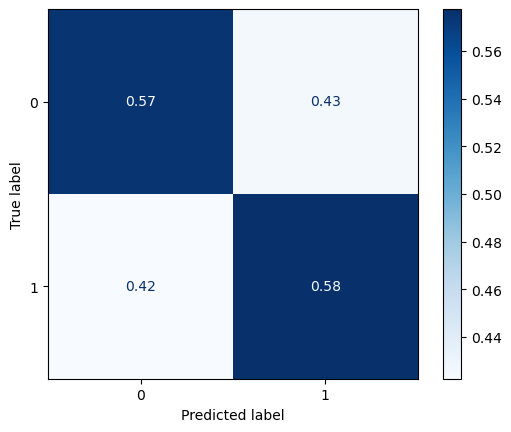

In [71]:
%%time
# Логистическая регрессия
model = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=RANDOM_STATE)

model.fit(X_train, y_train)

valid_predictions = model.predict(X_valid)
valid_probabilities = model.predict_proba(X_valid)[:, 1]
valid_accuracy = accuracy_score(y_valid, valid_predictions)

print('valid_accuracy: {:.2%}'.format(valid_accuracy))
ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid, cmap=plt.cm.Blues, normalize='true'); # матрица ошибок

C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Kvas6\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


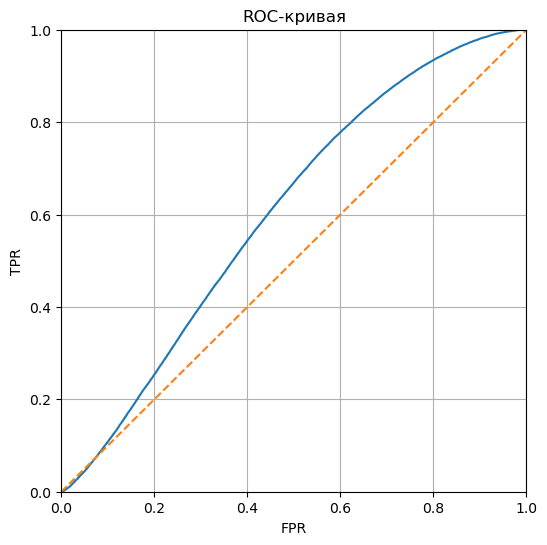

In [72]:
fpr, tpr, thresholds = roc_curve(y_valid, valid_probabilities)

plt.figure(figsize = (6, 6))
plt.step(fpr, tpr, where='post')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True)
plt.show()

Найдем 5 наиболее подходящих кандидатов для сопоставления

In [73]:
valid_proba_series = pd.Series(valid_probabilities)

valid_candidates = []
for i in range(0, len(valid_proba_series), NEIGHBORS):
    query = valid_proba_series[i : i+NEIGHBORS]
    index = query.sort_values(ascending=False)[0:N_CELLS].index
    valid_candidates.append(index)

# контроль
print('Кол-во предсказаний:', len(valid_candidates))
print('Кол-во кандидатов:', len(valid_candidates[0]))

Кол-во предсказаний: 100000
Кол-во кандидатов: 5


In [74]:
# оценка качества
acc = 0
for target, candidates in zip(data_validation_answer.values.tolist(), valid_candidates):
    acc += int(target in valid_base_data.loc[candidates, 'id_candidate'].values)

print('valid_accuracy@{}: {:.2f}%'.format(CELLS, acc / len(valid_candidates) * 100))

valid_accuracy@5: 70.93%


## Вывод

Что мы тмели на входе:
1) Отсутствие пропусков в данных.
2) Отсутствие дубликатов.
3) Нормальное распределение.
4) Отсутствие кореляции.

На первых итерациях проекта, мы пытались обойтись без дополнительной обработки данных, поскольку явнях проблем с ними не было. Первые итерации проекта показывали 20 - 30% качества, все зависило от типа применяеиого способа индексации. Мы испробовали многие метрики, при обучении модели. Сильного влияния на итоговый результат это не оказывало. 

Далее, были предлагаемые данные были более детально изучены, особо выделялись столбцы с ровным распределением данных - 59, 65. После удаления этих притериев, качество выросло, но не значительно, а только на 5%. Далее была детально изучена кореляция данных и выявлено, что критерии за номерами 25, 44, 65 и тд, немного выделяется из общей массы, хотя все так же находилась на не значительном уровне 0,1 - 0,2, но мною было принято решение удалить ити значения, что положительно сказалось на метрике.

Пространство поделено на 20 кластеров, что ускоряет и уточняет процесс поиска. Для каждого объекта из train были найдены 20 ближайших векторов при помощи меры FlatL2. Упомянутые числовые параметры были подобраны эмпирическим путём.  Критически важным параметром для увеличения качетсва метрики стало  - nprobe, это параметр в библиотеке Faiss, который определяет сколько кластеров (ячеек) индекс будет проверять при поиске ближайших соседей. Мною было практически найдено оптимальное значение, ладбнейшее увеличение ячеек не увеличивает метрику.

Далее, среди найденных кандидатов были выделены пятерки самых подходящий. Для этого их применялась Логистическая регрессия. Присутствующий негативный эффект дисбаланса классов был уменьшен с помощью штатного гиперпараметра модели class_weight, тем самым назначив разные веса для классов.